In [1]:
# Kaggle Comprtition URL!!!!!!!
# https://www.kaggle.com/competitions/nlp-getting-started/overview

import pandas as pd

dir_path = './data/'

In [2]:
train_data = pd.read_csv(dir_path + 'train.csv')
test_data = pd.read_csv(dir_path + 'test.csv')

In [3]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
import re
from nltk.stem import PorterStemmer
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score
from scipy.sparse import hstack
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import log_evaluation
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
train_data['text_length'] = train_data['text'].apply(len)
train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))
test_data['text_length'] = test_data['text'].apply(len)
test_data['word_count'] = test_data['text'].apply(lambda x: len(x.split()))

In [7]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, hstack

ohe = OneHotEncoder(sparse=False)
keyword_ohe_train = ohe.fit_transform(train_data[['keyword']])
keyword_ohe_test = ohe.transform(test_data[['keyword']])

In [8]:
stemmer = PorterStemmer()

def preprocess_text(text):

    text = text.lower()

    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    text = re.sub(r'\@|\#|\d+|[|]', '', text)

    words = text.split()
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

train_data['cleaned_text'] = train_data['text'].apply(preprocess_text)
test_data['cleaned_text'] = test_data['text'].apply(preprocess_text)

In [9]:
pd.DataFrame({'text':train_data['text'], 'cleaned_text':train_data['cleaned_text']})

,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,our deed are the reason of thi earthquak may a...
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask. canada
2,All residents asked to 'shelter in place' are ...,all resid ask to 'shelter in place' are be not...
3,"13,000 people receive #wildfires evacuation or...",", peopl receiv wildfir evacu order in california"
4,Just got sent this photo from Ruby #Alaska as ...,just got sent thi photo from rubi alaska as sm...
...,...,...
7608,Two giant cranes holding a bridge collapse int...,two giant crane hold a bridg collaps into near...
7609,@aria_ahrary @TheTawniest The out of control w...,aria_ahrari thetawniest the out of control wil...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,m. [: utc]?km s of volcano hawaii.
7611,Police investigating after an e-bike collided ...,polic investig after an e-bik collid with a ca...


In [10]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=4000, ngram_range=(1, 2))

X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['cleaned_text'])

In [11]:
numeric_features_train = csr_matrix(train_data[['text_length', 'word_count']].values)
numeric_features_test = csr_matrix(test_data[['text_length', 'word_count']].values)

In [12]:
X_train = hstack([keyword_ohe_train, numeric_features_train, X_train_tfidf])
X_test = hstack([keyword_ohe_test, numeric_features_test, X_test_tfidf])

y_train = train_data['target']

In [13]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# XGBoost

In [14]:
# å®?ç¾? XGBoost è¶??????¸æ??ç´¢ç??ç¶²æ?¼
xgb_param_grid = {
    'n_estimators': [300],
    'learning_rate': [0.1],
    'max_depth': [4],
    'reg_lambda': [10],
    'reg_alpha': [0],
    'min_child_weight': [1, 5, 10],
    'eval_metric': ['logloss']
}


# ???å§???? XGBoost æ¨¡å??
xgb = XGBClassifier(random_state=42)

# ä½¿ç?? GridSearchCV å°???? XGBoost ???ä½³å????¸
xgb_grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=1
)

# ??¨è??ç·´é??ä¸????ç´¢æ??ä½³å????¸
xgb_grid_search.fit(X_train_split, y_train_split)

# è¼¸å?ºæ??ä½³å????¸
xgb_best_params = xgb_grid_search.best_params_
print("XGBoost Best Parameters:", xgb_best_params)

xgb_results = pd.DataFrame(xgb_grid_search.cv_results_)
xgb_important_results = xgb_results[['param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_eval_metric', 'mean_test_score']]
print(xgb_important_results.sort_values(by='mean_test_score', ascending=False))

XGBoost Best Parameters: {'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 10}
  param_n_estimators param_learning_rate param_max_depth param_eval_metric  \
0                300                 0.1               4           logloss   
1                300                 0.1               4           logloss   
2                300                 0.1               4           logloss   

   mean_test_score  
0         0.731863  
1         0.726646  
2         0.693048  


In [15]:
# ä½¿ç?¨æ??ä½³å????¸é????°è??ç·´
eval_set = [(X_train_split, y_train_split), (X_val, y_val)]
best_xgb = XGBClassifier(
    n_estimators=xgb_best_params['n_estimators'],
    learning_rate=xgb_best_params['learning_rate'],
    max_depth=xgb_best_params['max_depth'],
    min_child_weight=xgb_best_params['min_child_weight'],
    eval_metric=xgb_best_params['eval_metric'],
    reg_alpha=xgb_best_params['reg_alpha'],  # L1 æ­???????
    reg_lambda=xgb_best_params['reg_lambda'],  # L2 æ­???????
    random_state=42
)

# ??·è??äº¤å??é©?è­?ï¼?ä½¿ç?¨è??ç·´æ?¸æ?? (X_train_split, y_train_split)
cv_scores = cross_val_score(best_xgb, X_train_split, y_train_split, cv=5)  # 5 ???äº¤å??é©?è­?

# æ¨¡å??è¨?ç·´
best_xgb.fit(X_train_split, y_train_split, eval_set=eval_set, verbose=False)

# æ¨¡å??è©?ä¼°ï??è¨?ç®?æº?ç¢ºç??
train_preds = best_xgb.predict(X_train_split)
val_preds = best_xgb.predict(X_val)

train_accuracy = accuracy_score(y_train_split, train_preds)
val_accuracy = accuracy_score(y_val, val_preds)

# è¼¸å?ºæ??ç¢ºç?????äº¤å??é©?è­?çµ??????????ä½³å????¸
print("Best Parameters:", xgb_best_params)
print(f"\näº¤å??é©?è­???????: {cv_scores}")
print(f"å¹³å??äº¤å??é©?è­???????: {cv_scores.mean():.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# æ¨¡å??è©?ä¼°ï?????é¡???±å??
train_report = classification_report(y_train_split, train_preds)
val_report = classification_report(y_val, val_preds)

# è¼¸å?ºç?????
print("\nTraining Classification Report:")
print(train_report)
print("\nValidation Classification Report:")
print(val_report)

Best Parameters: {'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 10}

äº¤å??é©?è­???????: [0.75369458 0.77668309 0.7454844  0.74794745 0.76847291]
å¹³å??äº¤å??é©?è­???????: 0.7585
Training Accuracy: 0.8041
Validation Accuracy: 0.7630

Training Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.95      0.85      3468
           1       0.90      0.61      0.73      2622

    accuracy                           0.80      6090
   macro avg       0.83      0.78      0.79      6090
weighted avg       0.82      0.80      0.80      6090


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.81       874
           1       0.82      0.57      0.67       649

    accuracy                           0.76      1523
   macro avg       0.78      0.74      0.74      1523
weighted

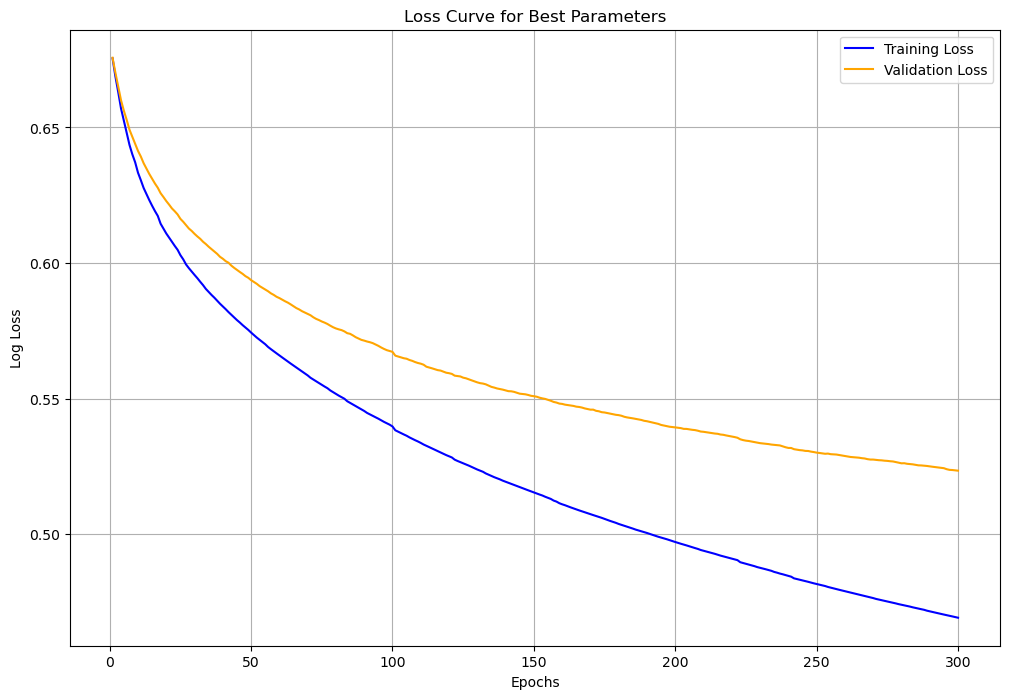

In [16]:
# ??²å??æ­·å?²æ??å¤±å?¼
results = best_xgb.evals_result()

# ç¹ªè£½???å¤±æ?²ç??
epochs = range(1, len(results['validation_0']['logloss']) + 1)
plt.figure(figsize=(12, 8))
plt.plot(epochs, results['validation_0']['logloss'], label='Training Loss', color='blue')
plt.plot(epochs, results['validation_1']['logloss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Loss Curve for Best Parameters')
plt.legend()
plt.grid(True)
plt.show()

# Random Forest

In [17]:
# å®?ç¾? Random Forest è¶??????¸æ??ç´¢ç??ç¶²æ?¼
rf_param_grid = {
    'n_estimators': [300],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

# ???å§???? Random Forest æ¨¡å??
rf = RandomForestClassifier(random_state=42)

# ä½¿ç?? GridSearchCV å°???? Random Forest ???ä½³å????¸
rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1
)

# ??¨è??ç·´é??ä¸????ç´¢æ??ä½³å????¸
rf_grid_search.fit(X_train, y_train)

# è¼¸å?? Random Forest ???ä½³å????¸å??çµ????
rf_best_params = rf_grid_search.best_params_
print("Random Forest Best Parameters:", rf_best_params)
rf_results = pd.DataFrame(rf_grid_search.cv_results_)
rf_important_results = rf_results[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_class_weight', 'mean_test_score']]
print("F1-Scores for each parameter combination:")
print(rf_important_results.sort_values(by='mean_test_score', ascending=False))

Random Forest Best Parameters: {'class_weight': 'balanced', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
F1-Scores for each parameter combination:
   param_n_estimators param_max_depth param_min_samples_split  \
8                 300               8                       2   
9                 300               8                       5   
10                300               8                       2   
11                300               8                       5   
6                 300               6                       2   
2                 300               4                       2   
7                 300               6                       5   
3                 300               4                       5   
1                 300               4                       5   
5                 300               6                       5   
0                 300               4                       2   
4                 300             

In [18]:
# ä½¿ç?? Random Forest ???ä½³å????¸é????°è??ç·´
best_rf = RandomForestClassifier(
    n_estimators=rf_best_params['n_estimators'],
    max_depth=rf_best_params['max_depth'],
    min_samples_split=rf_best_params['min_samples_split'],
    min_samples_leaf=rf_best_params['min_samples_leaf'],
    class_weight=rf_best_params['class_weight'],
    oob_score=True,  # ?????? OOB
    random_state=42
)

# ??·è??äº¤å??é©?è­?ï¼?ä½¿ç?¨è??ç·´æ?¸æ?? (X_train_split, y_train_split)
cv_scores = cross_val_score(best_rf, X_train_split, y_train_split, cv=5)  # 5 ???äº¤å??é©?è­?

# æ¨¡å??è¨?ç·´
best_rf.fit(X_train_split, y_train_split)

# è¨?ç·´é?????é©?è­???????æ¸¬
train_preds = best_rf.predict(X_train_split)
val_preds = best_rf.predict(X_val)

# è¨?ç®?æº?ç¢ºç??
train_accuracy = accuracy_score(y_train_split, train_preds)
val_accuracy = accuracy_score(y_val, val_preds)

# è¼¸å?ºæ??ç¢ºç????????ä½³å????¸
print("Best Parameters:", rf_best_params)
print(f"\näº¤å??é©?è­???????: {cv_scores}")
print(f"å¹³å??äº¤å??é©?è­???????: {cv_scores.mean():.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# è¨?ç·´é?????é©?è­??????????é¡???±å??
train_report = classification_report(y_train_split, train_preds)
val_report = classification_report(y_val, val_preds)

# è¼¸å?ºç?????
print("\nTraining Classification Report:")
print(train_report)
print("\nValidation Classification Report:")
print(val_report)

Best Parameters: {'class_weight': 'balanced', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

äº¤å??é©?è­???????: [0.73891626 0.7545156  0.73809524 0.73316913 0.7635468 ]
å¹³å??äº¤å??é©?è­???????: 0.7456
Training Accuracy: 0.7739
Validation Accuracy: 0.7472

Training Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      3468
           1       0.90      0.53      0.67      2622

    accuracy                           0.77      6090
   macro avg       0.82      0.74      0.75      6090
weighted avg       0.80      0.77      0.76      6090


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       874
           1       0.83      0.51      0.63       649

    accuracy                           0.75      1523
   macro avg       0.77      0.72      0.72      1523
weighted avg       0.76      0.75     

c:\Users\clair\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


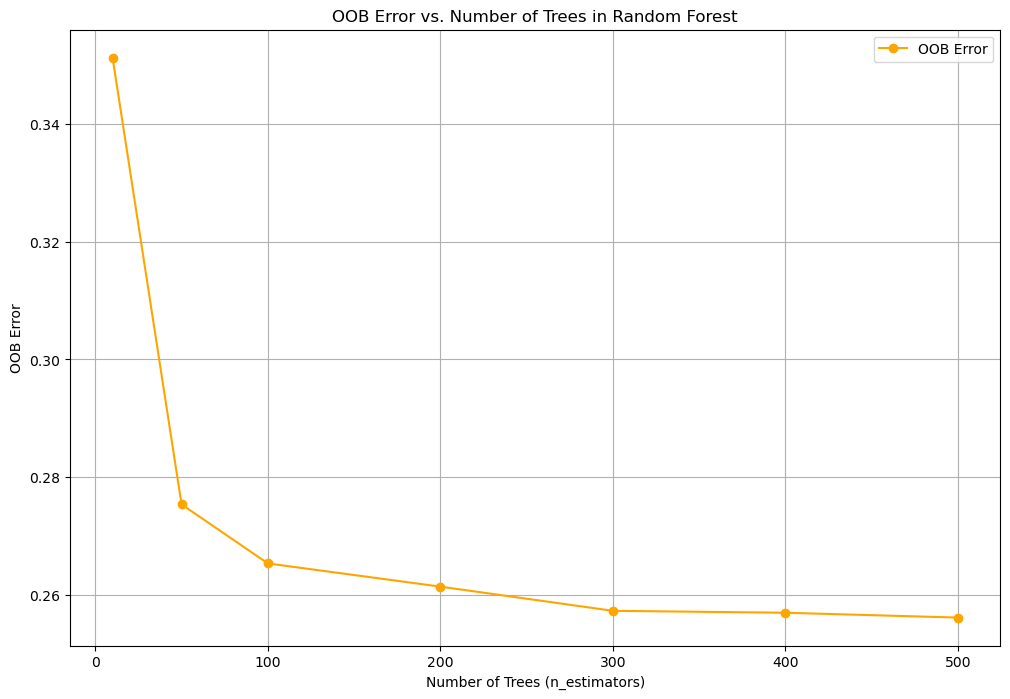

In [19]:
oob_errors = []
n_estimators_range = [10, 50, 100, 200, 300, 400, 500]

# è¨?ç·´ä????? n_estimators ??? Random Forest
for n in n_estimators_range:
    rf = RandomForestClassifier(
        n_estimators=n,
        max_depth=rf_best_params['max_depth'],
        min_samples_split=rf_best_params['min_samples_split'],
        min_samples_leaf=rf_best_params['min_samples_leaf'],
        class_weight=rf_best_params['class_weight'],
        oob_score=True,
        random_state=42
    )
    rf.fit(X_train_split, y_train_split)
    oob_errors.append(1 - rf.oob_score_)

# ç¹ªè£½ OOB èª¤å·®??²ç??
plt.figure(figsize=(12, 8))
plt.plot(n_estimators_range, oob_errors, marker='o', linestyle='-', color='orange', label='OOB Error')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('OOB Error')
plt.title('OOB Error vs. Number of Trees in Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# LightGBM

In [49]:
# å®?ç¾? LightGBM è¶??????¸æ??ç´¢ç??ç¶²æ?¼
lgb_param_grid = {
    'n_estimators': [300],  # æ¨¹ç????¸é??
    'learning_rate': [0.01],  # å­¸ç?????
    'max_depth': [6],  # æ¨¹ç?????å¤§æ·±åº¦
    'num_leaves': [31, 63],  # ??§å?¶æ¨¹???è¤????åº¦
    'subsample': [0.8],  # æ¨???¬ç????¨æ??æ¯?ä¾?
    'colsample_bytree': [0.8],  # ??¹å¾µ?????¨æ??æ¯?ä¾?
    'min_child_weight': [0.1],  # ??§å?¶è??å­?ç¯?é»???????å°?æ¬????
    'class_weight': ['balanced'],  # ??¯å?¦å¹³è¡¡é????¥æ?????
    'lambda_l1': [0],           # L1æ­???????
    'lambda_l2': [0]            # L2æ­???????
}

# ???å§???? LightGBM æ¨¡å??
lgbm = LGBMClassifier(random_state=42)

# ä½¿ç?? GridSearchCV å°???? LightGBM ???ä½³å????¸
lgb_grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=lgb_param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1
)

# ??¨è??ç·´é??ä¸????ç´¢æ??ä½³å????¸
lgb_grid_search.fit(X_train_split, y_train_split)

# è¼¸å?? LightGBM ???ä½³å????¸
lgb_best_params = lgb_grid_search.best_params_
print("LightGBM Best Parameters:", lgb_best_params)

# å°????ç´¢ç?????å­???? DataFrame ä¸¦æ??åº?
lgb_results = pd.DataFrame(lgb_grid_search.cv_results_)
lgb_important_results = lgb_results[['param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_num_leaves', 'param_subsample', 'param_colsample_bytree', 'param_min_child_weight', 'param_class_weight', 'mean_test_score']]
print("F1-Scores for each parameter combination:")
print(lgb_important_results.sort_values(by='mean_test_score', ascending=False))

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 2622, number of negative: 3468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9159
[LightGBM] [Info] Number of data points in the train set: 6090, number of used features: 829
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with posi

In [74]:
import optuna

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'f1',
        'boosting_type': 'gbdt',
        'class_weight': 'balanced',
        'n_estimators': 300,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'num_leaves': trial.suggest_int('num_leaves', 31, 127),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.3, 0.5),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.3, 0.5)
    }

    model = LGBMClassifier(**param, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return f1_score(y_val, preds, average='macro')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# è¼¸å?? LightGBM ???ä½³å????¸
lgb_best_params = study.best_params
print("LightGBM Best Parameters:", lgb_best_params)

[I 2025-01-14 15:57:51,434] A new study created in memory with name: no-name-c6a4935b-bfd4-4bad-9a84-b0e76217fa66


[LightGBM] [Warning] lambda_l1 is set=0.49088996825698655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49088996825698655
[LightGBM] [Warning] lambda_l2 is set=0.4927548365230315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4927548365230315
[LightGBM] [Warning] lambda_l1 is set=0.49088996825698655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49088996825698655
[LightGBM] [Warning] lambda_l2 is set=0.4927548365230315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4927548365230315
[LightGBM] [Info] Number of positive: 3271, number of negative: 4342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12097
[LightGBM] [Info] Number of data points in the train set: 7613, number of used features: 989
[LightGBM] [Info] [binary:BoostFromScor

[I 2025-01-14 15:57:51,977] Trial 0 finished with value: 0.8083656888121945 and parameters: {'learning_rate': 0.07359201906472342, 'max_depth': 5, 'num_leaves': 35, 'min_child_weight': 0.07902196629706265, 'subsample': 0.7935746287713745, 'colsample_bytree': 0.8546446851088654, 'lambda_l1': 0.49088996825698655, 'lambda_l2': 0.4927548365230315}. Best is trial 0 with value: 0.8083656888121945.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:57:52,396] Trial 1 finished with value: 0.8027384586918309 and parameters: {'learning_rate': 0.06248216232082821, 'max_depth': 5, 'num_leaves': 42, 'min_child_weight': 0.09025576536790106, 'subsample': 0.768381300629358, 'colsample_bytree': 0.663643452586394, 'lambda_l1': 0.43533680798908947, 'lambda_l2': 0.38025714708792}. Best is trial 0 with value: 0.8083656888121945.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:57:53,512] Trial 2 finished with value: 0.7959834542780326 and parameters: {'learning_rate': 0.026288750756314747, 'max_depth': 8, 'num_leaves': 83, 'min_child_weight': 0.07776029704733849, 'subsample': 0.8930843258573058, 'colsample_bytree': 0.8125774181609116, 'lambda_l1': 0.3220088388848476, 'lambda_l2': 0.3534658525690492}. Best is trial 0 with value: 0.8083656888121945.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.3220088388848476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3220088388848476
[LightGBM] [Warning] lambda_l2 is set=0.3534658525690492, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3534658525690492
[LightGBM] [Warning] lambda_l1 is set=0.45234829240605134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45234829240605134
[LightGBM] [Warning] lambda_l2 is set=0.44404878019260274, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.44404878019260274
[LightGBM] [Warning] lambda_l1 is set=0.45234829240605134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45234829240605134
[LightGBM] [Warning] lambda_l2 is set=0.44404878019260274, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.44404878019260274
[LightGBM] [Info] Number of positive: 327

[I 2025-01-14 15:57:54,072] Trial 3 finished with value: 0.8147341154414475 and parameters: {'learning_rate': 0.057446912291195334, 'max_depth': 8, 'num_leaves': 70, 'min_child_weight': 0.08387590231576335, 'subsample': 0.8524972017243845, 'colsample_bytree': 0.7806885327069002, 'lambda_l1': 0.45234829240605134, 'lambda_l2': 0.44404878019260274}. Best is trial 3 with value: 0.8147341154414475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:57:54,584] Trial 4 finished with value: 0.8001464274595831 and parameters: {'learning_rate': 0.05405664626003099, 'max_depth': 5, 'num_leaves': 41, 'min_child_weight': 0.07103708726100098, 'subsample': 0.8716033167449112, 'colsample_bytree': 0.6927285097686555, 'lambda_l1': 0.34281596702968287, 'lambda_l2': 0.4461675137095508}. Best is trial 3 with value: 0.8147341154414475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:57:55,149] Trial 5 finished with value: 0.8192663717991145 and parameters: {'learning_rate': 0.09293103843936784, 'max_depth': 6, 'num_leaves': 100, 'min_child_weight': 0.0058002298872088, 'subsample': 0.6345275801346304, 'colsample_bytree': 0.7713296492018412, 'lambda_l1': 0.34454758455399237, 'lambda_l2': 0.329277582874302}. Best is trial 5 with value: 0.8192663717991145.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.34454758455399237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34454758455399237
[LightGBM] [Warning] lambda_l2 is set=0.329277582874302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.329277582874302
[LightGBM] [Warning] lambda_l1 is set=0.4051436190593748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4051436190593748
[LightGBM] [Warning] lambda_l2 is set=0.4994234664100553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4994234664100553
[LightGBM] [Warn

[I 2025-01-14 15:57:56,105] Trial 6 finished with value: 0.8127908406061777 and parameters: {'learning_rate': 0.042726932848919874, 'max_depth': 8, 'num_leaves': 40, 'min_child_weight': 0.05346199482787451, 'subsample': 0.6350213638518073, 'colsample_bytree': 0.8456528681028245, 'lambda_l1': 0.4051436190593748, 'lambda_l2': 0.4994234664100553}. Best is trial 5 with value: 0.8192663717991145.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:57:56,688] Trial 7 finished with value: 0.8253584316086331 and parameters: {'learning_rate': 0.06453747635055314, 'max_depth': 8, 'num_leaves': 73, 'min_child_weight': 0.08403872430727242, 'subsample': 0.6053623399029963, 'colsample_bytree': 0.6712750000642708, 'lambda_l1': 0.43225375765256835, 'lambda_l2': 0.36180536010360353}. Best is trial 7 with value: 0.8253584316086331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:57:57,338] Trial 8 finished with value: 0.7972398791431712 and parameters: {'learning_rate': 0.025413747564802507, 'max_depth': 8, 'num_leaves': 119, 'min_child_weight': 0.01003840296945422, 'subsample': 0.733306257373084, 'colsample_bytree': 0.7679271800085304, 'lambda_l1': 0.3946755000236924, 'lambda_l2': 0.4893049970943913}. Best is trial 7 with value: 0.8253584316086331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:57:57,828] Trial 9 finished with value: 0.815209771354616 and parameters: {'learning_rate': 0.06188968473472868, 'max_depth': 7, 'num_leaves': 42, 'min_child_weight': 0.08493464148591812, 'subsample': 0.7998072445126299, 'colsample_bytree': 0.6405656490489621, 'lambda_l1': 0.3757812082417866, 'lambda_l2': 0.400648665123687}. Best is trial 7 with value: 0.8253584316086331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:57:58,461] Trial 10 finished with value: 0.8105721393034826 and parameters: {'learning_rate': 0.09489317505359532, 'max_depth': 4, 'num_leaves': 66, 'min_child_weight': 0.03276471409061224, 'subsample': 0.6949536247901484, 'colsample_bytree': 0.6091588587575348, 'lambda_l1': 0.4790999875083147, 'lambda_l2': 0.30340674425968417}. Best is trial 7 with value: 0.8253584316086331.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:57:58,933] Trial 11 finished with value: 0.8275410481746794 and parameters: {'learning_rate': 0.0987424448815446, 'max_depth': 6, 'num_leaves': 100, 'min_child_weight': 0.0017733328101640971, 'subsample': 0.6103361881659349, 'colsample_bytree': 0.7137848978534524, 'lambda_l1': 0.3597353264839214, 'lambda_l2': 0.3206680539501554}. Best is trial 11 with value: 0.8275410481746794.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:57:59,448] Trial 12 finished with value: 0.8189774611588367 and parameters: {'learning_rate': 0.07976505376684934, 'max_depth': 6, 'num_leaves': 95, 'min_child_weight': 0.034177262971064076, 'subsample': 0.6783087363568908, 'colsample_bytree': 0.7072918850439097, 'lambda_l1': 0.42624981501831727, 'lambda_l2': 0.3516846947590615}. Best is trial 11 with value: 0.8275410481746794.


[LightGBM] [Warning] lambda_l1 is set=0.42624981501831727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42624981501831727
[LightGBM] [Warning] lambda_l2 is set=0.3516846947590615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3516846947590615
[LightGBM] [Warning] lambda_l1 is set=0.3735571661302365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3735571661302365
[LightGBM] [Warning] lambda_l2 is set=0.3015199538512199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3015199538512199
[LightGBM] [Warning] lambda_l1 is set=0.3735571661302365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3735571661302365
[LightGBM] [Warning] lambda_l2 is set=0.3015199538512199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3015199538512199
[LightGBM] [Info] Number of positive: 3271, number of negative: 4342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015416 seconds.
You can set `force_row_w

[I 2025-01-14 15:58:00,070] Trial 13 finished with value: 0.8254503778517962 and parameters: {'learning_rate': 0.08156760409468951, 'max_depth': 7, 'num_leaves': 127, 'min_child_weight': 0.05269656870613154, 'subsample': 0.6203668520393064, 'colsample_bytree': 0.7193146229142662, 'lambda_l1': 0.3735571661302365, 'lambda_l2': 0.3015199538512199}. Best is trial 11 with value: 0.8275410481746794.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:00,650] Trial 14 finished with value: 0.8269045590572602 and parameters: {'learning_rate': 0.08156039809086957, 'max_depth': 7, 'num_leaves': 125, 'min_child_weight': 0.049118331663019286, 'subsample': 0.604289610375648, 'colsample_bytree': 0.7336731198875838, 'lambda_l1': 0.3670296510055718, 'lambda_l2': 0.30128957377606047}. Best is trial 11 with value: 0.8275410481746794.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:01,326] Trial 15 finished with value: 0.8351678527089349 and parameters: {'learning_rate': 0.09967211006533765, 'max_depth': 7, 'num_leaves': 111, 'min_child_weight': 0.023435902107323422, 'subsample': 0.6756322063506182, 'colsample_bytree': 0.7539915426641721, 'lambda_l1': 0.3113915327790039, 'lambda_l2': 0.32612786139469246}. Best is trial 15 with value: 0.8351678527089349.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:01,905] Trial 16 finished with value: 0.8258109711638812 and parameters: {'learning_rate': 0.09926079201123313, 'max_depth': 6, 'num_leaves': 109, 'min_child_weight': 0.01888939354118344, 'subsample': 0.678380205133969, 'colsample_bytree': 0.8944506468934208, 'lambda_l1': 0.30297078127375643, 'lambda_l2': 0.33287453303165027}. Best is trial 15 with value: 0.8351678527089349.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:02,457] Trial 17 finished with value: 0.8283566069531056 and parameters: {'learning_rate': 0.08682688572433998, 'max_depth': 7, 'num_leaves': 90, 'min_child_weight': 0.02192717068723363, 'subsample': 0.7131525191473931, 'colsample_bytree': 0.8076446121698605, 'lambda_l1': 0.31622079279234583, 'lambda_l2': 0.4074911991432633}. Best is trial 15 with value: 0.8351678527089349.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:03,032] Trial 18 finished with value: 0.8284449927586762 and parameters: {'learning_rate': 0.08834615881678937, 'max_depth': 7, 'num_leaves': 83, 'min_child_weight': 0.024596017818865, 'subsample': 0.714157522397305, 'colsample_bytree': 0.8114850933259666, 'lambda_l1': 0.30089441282776525, 'lambda_l2': 0.40633826704337583}. Best is trial 15 with value: 0.8351678527089349.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:03,674] Trial 19 finished with value: 0.81078701453033 and parameters: {'learning_rate': 0.04494620478755959, 'max_depth': 7, 'num_leaves': 57, 'min_child_weight': 0.038962363689467906, 'subsample': 0.6567385829317534, 'colsample_bytree': 0.817243737326199, 'lambda_l1': 0.3301052089409344, 'lambda_l2': 0.4242037793378932}. Best is trial 15 with value: 0.8351678527089349.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:04,622] Trial 20 finished with value: 0.7683062880324544 and parameters: {'learning_rate': 0.01462878689134714, 'max_depth': 7, 'num_leaves': 115, 'min_child_weight': 0.01997623111111103, 'subsample': 0.7495955822206858, 'colsample_bytree': 0.8906405581365339, 'lambda_l1': 0.309972072081308, 'lambda_l2': 0.37496422176396466}. Best is trial 15 with value: 0.8351678527089349.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:05,313] Trial 21 finished with value: 0.8255416028293647 and parameters: {'learning_rate': 0.0872745347372249, 'max_depth': 7, 'num_leaves': 86, 'min_child_weight': 0.02202893915066076, 'subsample': 0.727143437144252, 'colsample_bytree': 0.8032779111422526, 'lambda_l1': 0.30043994483314107, 'lambda_l2': 0.4102866720273289}. Best is trial 15 with value: 0.8351678527089349.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:05,863] Trial 22 finished with value: 0.8215453611972765 and parameters: {'learning_rate': 0.07256245891939059, 'max_depth': 7, 'num_leaves': 93, 'min_child_weight': 0.026448828574340107, 'subsample': 0.7106147716701353, 'colsample_bytree': 0.7559260963282035, 'lambda_l1': 0.32403359810949883, 'lambda_l2': 0.4253544494236004}. Best is trial 15 with value: 0.8351678527089349.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.32403359810949883, reg_alpha=0.0 will be ignored. Current va

[I 2025-01-14 15:58:06,377] Trial 23 finished with value: 0.8207244888139948 and parameters: {'learning_rate': 0.08790707576951663, 'max_depth': 6, 'num_leaves': 108, 'min_child_weight': 0.012650110754028726, 'subsample': 0.6679356289742432, 'colsample_bytree': 0.8451854445448058, 'lambda_l1': 0.33760723149845145, 'lambda_l2': 0.38202013646166394}. Best is trial 15 with value: 0.8351678527089349.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:06,912] Trial 24 finished with value: 0.8298935265272278 and parameters: {'learning_rate': 0.09019153845125968, 'max_depth': 7, 'num_leaves': 88, 'min_child_weight': 0.04298114990857316, 'subsample': 0.7121863563883779, 'colsample_bytree': 0.7923361447925495, 'lambda_l1': 0.3163899230062392, 'lambda_l2': 0.4600013503216898}. Best is trial 15 with value: 0.8351678527089349.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:07,457] Trial 25 finished with value: 0.8193611769418578 and parameters: {'learning_rate': 0.07281746488860312, 'max_depth': 7, 'num_leaves': 79, 'min_child_weight': 0.04385230658813587, 'subsample': 0.790372263284309, 'colsample_bytree': 0.7442751732403622, 'lambda_l1': 0.3478458049255904, 'lambda_l2': 0.47091287155923994}. Best is trial 15 with value: 0.8351678527089349.


[LightGBM] [Warning] lambda_l1 is set=0.3478458049255904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3478458049255904
[LightGBM] [Warning] lambda_l2 is set=0.47091287155923994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47091287155923994
[LightGBM] [Warning] lambda_l1 is set=0.30005480971172144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30005480971172144
[LightGBM] [Warning] lambda_l2 is set=0.47167847122547746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47167847122547746
[LightGBM] [Warning] lambda_l1 is set=0.30005480971172144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30005480971172144
[LightGBM] [Warning] lambda_l2 is set=0.47167847122547746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47167847122547746
[LightGBM] [Info] Number of positive: 3271, number of negative: 4342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014330 seconds.
You can set `for

[I 2025-01-14 15:58:08,052] Trial 26 finished with value: 0.837184855233853 and parameters: {'learning_rate': 0.09277689562818629, 'max_depth': 8, 'num_leaves': 77, 'min_child_weight': 0.06326575537635187, 'subsample': 0.7592232039381258, 'colsample_bytree': 0.7929800729629876, 'lambda_l1': 0.30005480971172144, 'lambda_l2': 0.47167847122547746}. Best is trial 26 with value: 0.837184855233853.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:08,578] Trial 27 finished with value: 0.835975516292605 and parameters: {'learning_rate': 0.09347726486874718, 'max_depth': 8, 'num_leaves': 59, 'min_child_weight': 0.06484580844788017, 'subsample': 0.8257951755667232, 'colsample_bytree': 0.7922548916771333, 'lambda_l1': 0.3180443975835029, 'lambda_l2': 0.4700451085307761}. Best is trial 26 with value: 0.837184855233853.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.3180443975835029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3180443975835029
[LightGBM] [Warning] lambda_l2 is set=0.4700451085307761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4700451085307761
[LightGBM] [Warning] lambda_l1 is set=0.3540983340681008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3540983340681008
[LightGBM] [Warning] lambda_l2 is set=0.4741345021864177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4741345021864177
[LightGBM] [Warning] lambda_l1 is set=0.3540983340681008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3540983340681008
[LightGBM] [Warning] lambda_l2 is set=0.4741345021864177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4741345021864177
[LightGBM] [Info] Number of positive: 3271, number of negative: 4342
[LightGBM] [Info] Auto-choosing row-wise multi-threadin

[I 2025-01-14 15:58:09,152] Trial 28 finished with value: 0.8405379840878824 and parameters: {'learning_rate': 0.09721079346128372, 'max_depth': 8, 'num_leaves': 56, 'min_child_weight': 0.06335082610436454, 'subsample': 0.8340904177318171, 'colsample_bytree': 0.7468722768322501, 'lambda_l1': 0.3540983340681008, 'lambda_l2': 0.4741345021864177}. Best is trial 28 with value: 0.8405379840878824.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:09,720] Trial 29 finished with value: 0.8298935265272278 and parameters: {'learning_rate': 0.07801687772070533, 'max_depth': 8, 'num_leaves': 56, 'min_child_weight': 0.06303769504348845, 'subsample': 0.8273287515623095, 'colsample_bytree': 0.8662511399010406, 'lambda_l1': 0.38984304141166676, 'lambda_l2': 0.480660339468207}. Best is trial 28 with value: 0.8405379840878824.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:10,392] Trial 30 finished with value: 0.8254503778517962 and parameters: {'learning_rate': 0.07171160193692577, 'max_depth': 8, 'num_leaves': 53, 'min_child_weight': 0.0634265583114351, 'subsample': 0.8319627274964104, 'colsample_bytree': 0.829692915648127, 'lambda_l1': 0.35281210487283987, 'lambda_l2': 0.461913383561075}. Best is trial 28 with value: 0.8405379840878824.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.35281210487283987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35281210487283987
[LightGBM] [Warning] lambda_l2 is set=0.461913383561075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.461913383561075
[LightGBM] [Warning] lambda_l1 is set=0.324708747609603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.324708747609603
[LightGBM] [Warning] lambda_l2 is set=0.44995441610080605, reg_lambda=0.0 wil

[I 2025-01-14 15:58:13,217] Trial 31 finished with value: 0.8415010587916332 and parameters: {'learning_rate': 0.09811881757357194, 'max_depth': 8, 'num_leaves': 62, 'min_child_weight': 0.061164897209901634, 'subsample': 0.8099037534516217, 'colsample_bytree': 0.7474310065202254, 'lambda_l1': 0.324708747609603, 'lambda_l2': 0.44995441610080605}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:13,784] Trial 32 finished with value: 0.836224063853531 and parameters: {'learning_rate': 0.09268479742798495, 'max_depth': 8, 'num_leaves': 49, 'min_child_weight': 0.09863174101348937, 'subsample': 0.7856894924821043, 'colsample_bytree': 0.7846770703771343, 'lambda_l1': 0.33126872698479654, 'lambda_l2': 0.44478019482626446}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:14,311] Trial 33 finished with value: 0.8363055776688096 and parameters: {'learning_rate': 0.09557588949194995, 'max_depth': 8, 'num_leaves': 50, 'min_child_weight': 0.09606417044904637, 'subsample': 0.7737300409448785, 'colsample_bytree': 0.7356872121226639, 'lambda_l1': 0.33136329865011016, 'lambda_l2': 0.4423324496960661}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:14,902] Trial 34 finished with value: 0.8346985291260378 and parameters: {'learning_rate': 0.08454302225628586, 'max_depth': 8, 'num_leaves': 64, 'min_child_weight': 0.07396514382196621, 'subsample': 0.7632453180496893, 'colsample_bytree': 0.7344008639529671, 'lambda_l1': 0.3330636570060367, 'lambda_l2': 0.43460612422011263}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:15,429] Trial 35 finished with value: 0.8380586372539208 and parameters: {'learning_rate': 0.09680491081367845, 'max_depth': 8, 'num_leaves': 34, 'min_child_weight': 0.09175120665149435, 'subsample': 0.8052512576901568, 'colsample_bytree': 0.680400536480412, 'lambda_l1': 0.3590038072596279, 'lambda_l2': 0.4550128705331318}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:15,993] Trial 36 finished with value: 0.8306170113266809 and parameters: {'learning_rate': 0.07693919657555434, 'max_depth': 8, 'num_leaves': 31, 'min_child_weight': 0.06929849168170654, 'subsample': 0.8112070250426843, 'colsample_bytree': 0.6899077751592346, 'lambda_l1': 0.35798476276297264, 'lambda_l2': 0.45796525391084786}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.35798476276297264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35798476276297264
[LightGBM] [Warning] lambda_l2 is set=0.45796525391084786, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45796525391084786
[LightGBM] [Warning] lambda_l1 is set=0.3830486901717376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3830486901717376
[LightGBM] [Warning] lambda_l2 is set=0.48527476344595755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.48527476344595755
[LightGBM] [Warning] lambda_l1 is set=0.3830486901717376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3830486901717376
[LightGBM] [Warning] lambda

[I 2025-01-14 15:58:16,429] Trial 37 finished with value: 0.790993138317082 and parameters: {'learning_rate': 0.06638845210351832, 'max_depth': 4, 'num_leaves': 74, 'min_child_weight': 0.058624290549099636, 'subsample': 0.8604637425220054, 'colsample_bytree': 0.6347402268405848, 'lambda_l1': 0.3830486901717376, 'lambda_l2': 0.48527476344595755}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:16,998] Trial 38 finished with value: 0.8386151208203578 and parameters: {'learning_rate': 0.09605042308162634, 'max_depth': 8, 'num_leaves': 67, 'min_child_weight': 0.07579579838317128, 'subsample': 0.8799556487606626, 'colsample_bytree': 0.6742809636674711, 'lambda_l1': 0.3449797395353882, 'lambda_l2': 0.46893666257910177}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] lambda_l1 is set=0.3449797395353882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3449797395353882
[LightGBM] [Warning] lambda_l2 is set=0.46893666257910177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.46893666257910177
[LightGBM] [Warning] lambda_l1 is set=0.4025921369559032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4025921369559032
[LightGBM] [Warning] lambda_l2 is set=0.45339399568763106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45339399568763106
[LightGBM] [Warning] lambda_l1 is set=0.4025921369559032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4025921369559032
[LightGBM] [Warning] lambda_l2 is set=0.45339399568763106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45339399568763106
[LightGBM] [Info] Number of positive: 3271, number of negative: 4342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013450 seconds.
You can set `force_r

[I 2025-01-14 15:58:17,428] Trial 39 finished with value: 0.7993970954666739 and parameters: {'learning_rate': 0.053679526186750794, 'max_depth': 5, 'num_leaves': 46, 'min_child_weight': 0.0904584107889164, 'subsample': 0.8913561966245975, 'colsample_bytree': 0.6654216170485704, 'lambda_l1': 0.4025921369559032, 'lambda_l2': 0.45339399568763106}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] lambda_l1 is set=0.4025921369559032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4025921369559032
[LightGBM] [Warning] lambda_l2 is set=0.45339399568763106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45339399568763106
[LightGBM] [Warning] lambda_l1 is set=0.34375883120707923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34375883120707923
[LightGBM] [Warning] lambda_l2 is set=0.497359706001889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.497359706001889
[LightGBM] [Warning] lambda_l1 is set=0.34375883120707923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34375883120707923
[LightGBM] [Warning] lambda_l2 is set=0.497359706001889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.497359706001889
[LightGBM] [Info] Number of positive: 3271, number of negative: 4342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014546 seconds.
You can set `force_row_w

[I 2025-01-14 15:58:18,057] Trial 40 finished with value: 0.829979816382667 and parameters: {'learning_rate': 0.0835806389622989, 'max_depth': 8, 'num_leaves': 68, 'min_child_weight': 0.07907396192095359, 'subsample': 0.845753308002426, 'colsample_bytree': 0.6392212760503312, 'lambda_l1': 0.34375883120707923, 'lambda_l2': 0.497359706001889}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:18,693] Trial 41 finished with value: 0.8329507758159445 and parameters: {'learning_rate': 0.09503120974943777, 'max_depth': 8, 'num_leaves': 77, 'min_child_weight': 0.07700673012628341, 'subsample': 0.8733194048613967, 'colsample_bytree': 0.688862272748764, 'lambda_l1': 0.41674807565329275, 'lambda_l2': 0.4775472111467873}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:19,222] Trial 42 finished with value: 0.83694430268619 and parameters: {'learning_rate': 0.09116090799659123, 'max_depth': 8, 'num_leaves': 62, 'min_child_weight': 0.055510842935919166, 'subsample': 0.8162057793331517, 'colsample_bytree': 0.7705108680589166, 'lambda_l1': 0.36015554393225274, 'lambda_l2': 0.47251299340488445}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] lambda_l1 is set=0.36015554393225274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36015554393225274
[LightGBM] [Warning] lambda_l2 is set=0.47251299340488445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47251299340488445
[LightGBM] [Warning] lambda_l1 is set=0.36841810191942986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36841810191942986
[LightGBM] [Warning] lambda_l2 is set=0.43153537914015466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43153537914015466
[LightGBM] [Warning] lambda_l1 is set=0.36841810191942986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36841810191942986
[LightGBM] [Warning] lambda_l2 is set=0.43153537914015466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43153537914015466
[LightGBM] [Info] Number of positive: 3271, number of negative: 4342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014721 seconds.
You can set `f

[I 2025-01-14 15:58:19,733] Trial 43 finished with value: 0.8363864269243404 and parameters: {'learning_rate': 0.09981757259022948, 'max_depth': 8, 'num_leaves': 34, 'min_child_weight': 0.07011981151272677, 'subsample': 0.8444652654697549, 'colsample_bytree': 0.6795126216001904, 'lambda_l1': 0.36841810191942986, 'lambda_l2': 0.43153537914015466}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:20,314] Trial 44 finished with value: 0.835747875131913 and parameters: {'learning_rate': 0.09605139020207605, 'max_depth': 8, 'num_leaves': 71, 'min_child_weight': 0.09012268532901382, 'subsample': 0.8780266356037387, 'colsample_bytree': 0.6549816772614616, 'lambda_l1': 0.3259722439662049, 'lambda_l2': 0.49048686718906137}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:20,944] Trial 45 finished with value: 0.830787518255308 and parameters: {'learning_rate': 0.09045445043093933, 'max_depth': 8, 'num_leaves': 41, 'min_child_weight': 0.07965022911354536, 'subsample': 0.7769611727865232, 'colsample_bytree': 0.6086058511045483, 'lambda_l1': 0.34154595254291475, 'lambda_l2': 0.45182874965182224}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:21,494] Trial 46 finished with value: 0.8077165871272378 and parameters: {'learning_rate': 0.03785146261745073, 'max_depth': 8, 'num_leaves': 61, 'min_child_weight': 0.05850419160120628, 'subsample': 0.8027716836172265, 'colsample_bytree': 0.7013050498447196, 'lambda_l1': 0.47899700485168145, 'lambda_l2': 0.4614132405513035}. Best is trial 31 with value: 0.8415010587916332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-14 15:58:22,006] Trial 47 finished with value: 0.841660609451754 and parameters: {'learning_rate': 0.09537150868991015, 'max_depth': 8, 'num_leaves': 67, 'min_child_weight': 0.06777905828989947, 'subsample': 0.7546712837059865, 'colsample_bytree': 0.7208958383694963, 'lambda_l1': 0.38118781274145414, 'lambda_l2': 0.46545722733662115}. Best is trial 47 with value: 0.841660609451754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.38118781274145414, reg_alpha=0.0 will be ignored. Current va

[I 2025-01-14 15:58:22,614] Trial 48 finished with value: 0.838140785196299 and parameters: {'learning_rate': 0.0967115156763081, 'max_depth': 8, 'num_leaves': 65, 'min_child_weight': 0.09011470699811307, 'subsample': 0.8576910520078542, 'colsample_bytree': 0.7198930561790202, 'lambda_l1': 0.3854824429730895, 'lambda_l2': 0.4376925209979129}. Best is trial 47 with value: 0.841660609451754.


[LightGBM] [Warning] lambda_l1 is set=0.3854824429730895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3854824429730895
[LightGBM] [Warning] lambda_l2 is set=0.4376925209979129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4376925209979129
[LightGBM] [Warning] lambda_l1 is set=0.38011731373712904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38011731373712904
[LightGBM] [Warning] lambda_l2 is set=0.4200931303998864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4200931303998864
[LightGBM] [Warning] lambda_l1 is set=0.38011731373712904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38011731373712904
[LightGBM] [Warning] lambda_l2 is set=0.4200931303998864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4200931303998864
[LightGBM] [Info] Number of positive: 3271, number of negative: 4342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014459 seconds.
You can set `force_row

[I 2025-01-14 15:58:23,115] Trial 49 finished with value: 0.8354204622584217 and parameters: {'learning_rate': 0.08416927889486067, 'max_depth': 8, 'num_leaves': 67, 'min_child_weight': 0.08424920951019199, 'subsample': 0.8637290401052543, 'colsample_bytree': 0.7203155703810245, 'lambda_l1': 0.38011731373712904, 'lambda_l2': 0.4200931303998864}. Best is trial 47 with value: 0.841660609451754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [77]:
# ??ªå??ç¾©é????¥æ?????
lgb_best_params['class_weight'] = {0: 1, 1: 1.1}  # å¢????å°? class 1 ??????æ³¨

# ä½¿ç?¨æ??ä½³å????¸é????°è??ç·´
best_lgbm = LGBMClassifier(
    **lgb_best_params,
    random_state=42
)

# ??·è??äº¤å??é©?è­?ï¼?ä½¿ç?¨è??ç·´æ?¸æ?? (X_train_split, y_train_split)
cv_scores = cross_val_score(best_lgbm, X_train_split, y_train_split, cv=5)  # 5 ???äº¤å??é©?è­?

# ???å§???????å¤±è?????
evals_result = {}

# è¨?ç·´æ¨¡???ä¸¦è?????çµ????
best_lgbm.fit(
    X_train_split,
    y_train_split,
    eval_set=[(X_train_split, y_train_split), (X_val, y_val)],
    eval_metric='logloss',
    callbacks=[log_evaluation(period=1)]
)

# æ¨¡å??è©?ä¼°ï??è¨?ç®?æº?ç¢ºç??
lgbm_train_preds = best_lgbm.predict(X_train_split)
lgbm_val_preds = best_lgbm.predict(X_val)

[LightGBM] [Warning] lambda_l1 is set=0.38118781274145414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38118781274145414
[LightGBM] [Warning] lambda_l2 is set=0.46545722733662115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.46545722733662115
[LightGBM] [Warning] lambda_l1 is set=0.38118781274145414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38118781274145414
[LightGBM] [Warning] lambda_l2 is set=0.46545722733662115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.46545722733662115
[LightGBM] [Info] Number of positive: 2097, number of negative: 2775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6563
[LightGBM] [Info] Number of data points in the train set: 4872, number of used features: 615
[LightGBM] [Info] [binary:BoostFromS

In [78]:
lgbm_train_accuracy = accuracy_score(y_train_split, lgbm_train_preds)
lgbm_val_accuracy = accuracy_score(y_val, lgbm_val_preds)

# è¼¸å?ºæ??ç¢ºç????????ä½³å????¸
print("LightGBM Best Parameters:", lgb_best_params)
print(f"\näº¤å??é©?è­???????: {cv_scores}")
print(f"å¹³å??äº¤å??é©?è­???????: {cv_scores.mean():.4f}")
print(f"Training Accuracy: {lgbm_train_accuracy:.4f}")
print(f"Validation Accuracy: {lgbm_val_accuracy:.4f}")

# æ¨¡å??è©?ä¼°ï?????é¡???±å??
lgbm_train_report = classification_report(y_train_split, lgbm_train_preds)
lgbm_val_report = classification_report(y_val, lgbm_val_preds)

# è¼¸å?ºç?????
print("\nTraining Classification Report:")
print(lgbm_train_report)
print("\nValidation Classification Report:")
print(lgbm_val_report)

LightGBM Best Parameters: {'learning_rate': 0.09537150868991015, 'max_depth': 8, 'num_leaves': 67, 'min_child_weight': 0.06777905828989947, 'subsample': 0.7546712837059865, 'colsample_bytree': 0.7208958383694963, 'lambda_l1': 0.38118781274145414, 'lambda_l2': 0.46545722733662115, 'class_weight': {0: 1, 1: 1.1}}

äº¤å??é©?è­???????: [0.76436782 0.78325123 0.75779967 0.76026273 0.77586207]
å¹³å??äº¤å??é©?è­???????: 0.7683
Training Accuracy: 0.8135
Validation Accuracy: 0.7630

Training Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      3468
           1       0.90      0.64      0.75      2622

    accuracy                           0.81      6090
   macro avg       0.84      0.79      0.80      6090
weighted avg       0.83      0.81      0.81      6090


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       874
           1      

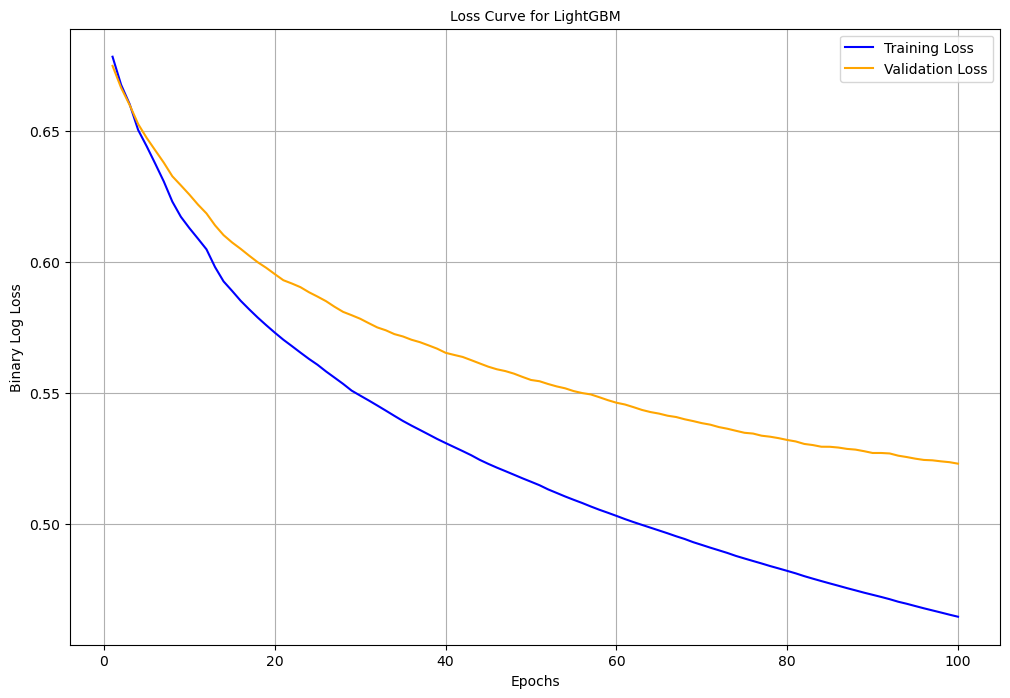

In [79]:
# ???è¨? lgb_best_params ?????«æ???????????ä½³è???????¸
# å®?ç¾©æ??????????¸å??ç¨±ç?????å¤§é?·åº¦
max_key_length = max(len(key) for key in lgb_best_params.keys())

# ä½¿ç?¨æ?¼å?????å­?ç¬¦ä¸²ä¾?å°?é½??????¸ï??ç¢ºä??æ¯?ä¸????å°?é½?
params_str = "\n".join([f"{key:<{max_key_length}} : {value}" for key, value in lgb_best_params.items()])

# ??²å??æ­·å?²æ??å¤±å?¼
eval_results = best_lgbm.evals_result_

# ç¹ªè£½???å¤±æ?²ç??
epochs = range(1, len(eval_results['training']['binary_logloss']) + 1)
plt.figure(figsize=(12, 8))
plt.plot(epochs, eval_results['training']['binary_logloss'], label='Training Loss', color='blue')
plt.plot(epochs, eval_results['valid_1']['binary_logloss'], label='Validation Loss', color='orange')

# è¨­å??æ¨?é¡?ä¸¦å????¥æ??ä½³å????¸
plt.xlabel('Epochs')
plt.ylabel('Binary Log Loss')

# è¨­ç½®æ¨?é¡?ä¸¦é¡¯ç¤ºå????¸
plt.title('Loss Curve for LightGBM', fontsize=10)

plt.legend()
plt.grid(True)
plt.show()

# Cat Boost

In [39]:
# ç¢ºä??é¡???¥å????¹å¾µ??¯å??ç¬¦ä¸²é¡????
train_data['keyword'] = train_data['keyword'].astype(str)
test_data['keyword'] = test_data['keyword'].astype(str)

# ???ä½µæ?¸å?¼ç?¹å¾µ??? TF-IDF ??¹å¾µ
X_train_tfidf_numeric = hstack([numeric_features_train, X_train_tfidf]).toarray()  # è½??????ºç??å¯???©é?£
X_test_tfidf_numeric = hstack([numeric_features_test, X_test_tfidf]).toarray()

# ???ä½µé????¥å????¹å¾µ?????¸å?¼å????¹å¾µ
X_train_combined = train_data[['keyword']].copy()
X_train_combined = pd.concat([X_train_combined, pd.DataFrame(X_train_tfidf_numeric)], axis=1)

X_test_combined = test_data[['keyword']].copy()
X_test_combined = pd.concat([X_test_combined, pd.DataFrame(X_test_tfidf_numeric)], axis=1)

# ç¢ºå??é¡???¥å????¹å¾µ
categorical_features = ['keyword']

In [83]:
# å®?ç¾? CatBoost è¶??????¸æ??ç´¢ç??ç¶²æ?¼
catboost_param_grid = {
    'iterations': [300],  # ç¸½è¿­ä»?æ¬¡æ?¸
    'learning_rate': [0.01],  # å­¸ç?????
    'depth': [6],  # æ¨¹ç??æ·±åº¦
    'l2_leaf_reg': [1],  # L2 æ­???????ä¿???¸
    'leaf_estimation_iterations': [1]  # ???å­?ä¼°è?????è¿­ä»£æ¬¡æ?¸
}

# ???å§???? CatBoost æ¨¡å??ï¼?æ³¨æ?????è£¡è¨­ç½? silent=True ç¦?æ­¢è??ç·´æ?¥è??è¼¸å?ºï??
catboost_model = CatBoostClassifier(
    cat_features=categorical_features,
    eval_metric='F1',
    random_state=42,
    verbose=0  # ç¦?æ­¢æ?¥è??è¼¸å?ºï??è®? GridSearchCV ??´ç°¡æ½?
)

# å®?ç¾? F1-score ä½???ºè??ä¼°æ??æ¨?
f1_scorer = make_scorer(f1_score, average='macro')

# ä½¿ç?? GridSearchCV ??²è?? CatBoost è¶??????¸æ??ç´¢
catboost_grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=catboost_param_grid,
    scoring=f1_scorer,  # ä½¿ç?? F1-macro ä½???ºç?®æ??
    cv=3,  # ä½¿ç?? 3 ???äº¤å??é©?è­?
    n_jobs=4  # ä½¿ç?¨æ???????¯ç?? CPU ??¸å??
)

# ??¨è??ç·´é??ä¸????ç´¢æ??ä½³å????¸
catboost_grid_search.fit(X_train_combined, y_train)

# ??²å?????ä½³å????¸è??è©?ä¼°ç?????
catboost_best_params = catboost_grid_search.best_params_
print("CatBoost Best Parameters:", catboost_best_params)
print("Best F1-score:", catboost_grid_search.best_score_)

# å°????ç´¢ç?????å­???? DataFrame ä¸¦æ??åº?
catboost_results = pd.DataFrame(catboost_grid_search.cv_results_)
catboost_important_results = catboost_results[['param_iterations', 'param_learning_rate', 'param_depth', 
                                                'param_l2_leaf_reg', 'param_leaf_estimation_iterations', 
                                                'mean_test_score']]
print("F1-Scores for each parameter combination:")
print(catboost_important_results.sort_values(by='mean_test_score', ascending=False))

c:\Users\clair\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1 fits failed out of a total of 6.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\clair\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\clair\anaconda3\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\clair\anaconda3\Lib\site-packages\catboost\core.py", line 241

CatBoost Best Parameters: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1, 'leaf_estimation_iterations': 1, 'learning_rate': 0.01}
Best F1-score: 0.4696415763893253
F1-Scores for each parameter combination:
  param_iterations param_learning_rate param_depth param_l2_leaf_reg  \
0              300                0.01           6                 1   
1              300                0.01           6                 3   

  param_leaf_estimation_iterations  mean_test_score  
0                                1         0.469642  
1                                1              NaN  


In [96]:
from sklearn.base import BaseEstimator, ClassifierMixin
from catboost import CatBoostClassifier
import numpy as np

class CatBoostWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, cat_features=None, **params):
        self.cat_features = cat_features
        self.params = params
        self.model = CatBoostClassifier(**params)
    
    def fit(self, X, y, **fit_params):
        # å°?ç¨??????©é??è½??????ºå???????©é?£
        if hasattr(X, "toarray"):
            X = X.toarray()
        self.model.fit(X, y, cat_features=self.cat_features, **fit_params)
        return self
    
    def predict(self, X):
        # ç¢ºä????¸æ????¼å??ä¸???´
        if hasattr(X, "toarray"):
            X = X.toarray()
        return self.model.predict(X)
    
    def predict_proba(self, X):
        # ç¢ºä????¸æ????¼å??ä¸???´
        if hasattr(X, "toarray"):
            X = X.toarray()
        return self.model.predict_proba(X)


In [97]:
# ä½¿ç?¨æ??ä½³å????¸é????°è??ç·? CatBoost æ¨¡å??
best_catboost = CatBoostWrapper(
    cat_features=[0],
    iterations=catboost_best_params['iterations'],
    learning_rate=catboost_best_params['learning_rate'],
    depth=catboost_best_params['depth'],
    l2_leaf_reg=catboost_best_params['l2_leaf_reg'],
    leaf_estimation_iterations=catboost_best_params['leaf_estimation_iterations'],
    random_state=42,
    verbose=0
)
# ?????²è?????ï¼?å°??????¨æ?? CatBoost
X_catboost_train, X_catboost_val, y_catboost_train, y_catboost_val = train_test_split(
    X_train_combined, y_train, test_size=0.2, random_state=42
)

# è¨?ç·? CatBoost æ¨¡å??
best_catboost.fit(
    X_catboost_train, y_catboost_train,
    eval_set=[(X_catboost_train, y_catboost_train), (X_catboost_val, y_catboost_val)],
    early_stopping_rounds=50,  # ?????????æ­¢
    use_best_model=True,
)


# æ¨¡å??è©?ä¼°ï??è¨?ç®?æº?ç¢ºç??
catboost_train_preds = best_catboost.predict(X_catboost_train)
catboost_val_preds = best_catboost.predict(X_catboost_val)

catboost_train_accuracy = accuracy_score(y_catboost_train, catboost_train_preds)
catboost_val_accuracy = accuracy_score(y_catboost_val, catboost_val_preds)

# è¼¸å?ºæ??ç¢ºç????????ä½³å????¸
print("CatBoost Best Parameters:", catboost_best_params)
print(f"Training Accuracy: {catboost_train_accuracy:.4f}")
print(f"Validation Accuracy: {catboost_val_accuracy:.4f}")

# æ¨¡å??è©?ä¼°ï?????é¡???±å??
catboost_train_report = classification_report(y_catboost_train, catboost_train_preds)
catboost_val_report = classification_report(y_catboost_val, catboost_val_preds)

# è¼¸å?ºç?????
print("\nTraining Classification Report:")
print(catboost_train_report)
print("\nValidation Classification Report:")
print(catboost_val_report)

CatBoost Best Parameters: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1, 'leaf_estimation_iterations': 1, 'learning_rate': 0.01}
Training Accuracy: 0.7713
Validation Accuracy: 0.7413

Training Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      3468
           1       0.75      0.70      0.73      2622

    accuracy                           0.77      6090
   macro avg       0.77      0.76      0.76      6090
weighted avg       0.77      0.77      0.77      6090


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       874
           1       0.70      0.70      0.70       649

    accuracy                           0.74      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.74      0.74      0.74      1523



# Stacking

In [99]:
from scipy.sparse import issparse

# å¦??????¯ç???????©é??ï¼?è½??????ºå???????¼å??
if issparse(X_train_split):
    X_train_split = X_train_split.toarray()
if issparse(X_val):
    X_val = X_val.toarray()


In [100]:
# å®?ç¾©å?ºå­¸ç¿???¨ï???????«ä½¿??¨æ??ä½³å????¸ç?? XGBoost???Random Forest ??? LightGBM
estimators = [
    ('xgb', best_xgb),
    ('rf', best_rf),
    ('lgb', best_lgbm),
    ('catboost', best_catboost)
]

# å®?ç¾©å??å­¸ç????¨ï?????è¼¯å??æ­¸ï??
stacking_model = StackingClassifier(
    estimators=estimators,  # ??ºå­¸ç¿???¨
    final_estimator=LogisticRegression(),  # ???å­¸ç????¨
    cv=5  # ä½¿ç?¨äº¤???é©?è­?
)

# è¨?ç®?äº¤å??é©?è­??????¸
cv_scores = cross_val_score(stacking_model, X_train_split, y_train_split, cv=5)

# ??¨è??ç·´å?????ä¸?è¨?ç·? Stacking æ¨¡å??
stacking_model.fit(X_train_split, y_train_split)

# ??¨è??ç·´é??ä¸???²è?????æ¸¬
stacking_train_preds = stacking_model.predict(X_train_split)
stacking_val_preds = stacking_model.predict(X_val)

# è¨?ç®?æº?ç¢ºç??
stacking_train_accuracy = accuracy_score(y_train_split, stacking_train_preds)
stacking_val_accuracy = accuracy_score(y_val, stacking_val_preds)

[LightGBM] [Warning] lambda_l1 is set=0.38118781274145414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38118781274145414
[LightGBM] [Warning] lambda_l2 is set=0.46545722733662115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.46545722733662115
[LightGBM] [Warning] lambda_l1 is set=0.38118781274145414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38118781274145414
[LightGBM] [Warning] lambda_l2 is set=0.46545722733662115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.46545722733662115
[LightGBM] [Info] Number of positive: 2097, number of negative: 2775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6563
[LightGBM] [Info] Number of data points in the train set: 4872, number of used features: 615
[LightGBM] [Info] [binary:BoostFromS

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\clair\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\clair\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py", line 658, in fit
    return super().fit(X, y_encoded, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\clair\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\clair\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py", line 206, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\clair\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 65, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\clair\anaconda3\Lib\site-packages\joblib\parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\clair\anaconda3\Lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\clair\anaconda3\Lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\clair\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
             ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\clair\anaconda3\Lib\site-packages\joblib\_parallel_backends.py", line 597, in __init__
    self.results = batch()
                   ^^^^^^^
  File "c:\Users\clair\anaconda3\Lib\site-packages\joblib\parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\clair\anaconda3\Lib\site-packages\joblib\parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\clair\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 127, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\clair\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py", line 36, in _fit_single_estimator
    estimator.fit(X, y)
  File "C:\Users\clair\AppData\Local\Temp\ipykernel_29456\3825120664.py", line 15, in fit
    self.model.fit(X, y, cat_features=self.cat_features, **fit_params)
  File "c:\Users\clair\anaconda3\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\clair\anaconda3\Lib\site-packages\catboost\core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\clair\anaconda3\Lib\site-packages\catboost\core.py", line 2275, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs, graph,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\clair\anaconda3\Lib\site-packages\catboost\core.py", line 1513, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, graph=graph, weight=sample_weight, group_id=group_id,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\clair\anaconda3\Lib\site-packages\catboost\core.py", line 797, in __init__
    raise CatBoostError(
_catboost.CatBoostError: 'data' is numpy array of floating point numerical type, it means no categorical features, but 'cat_features' parameter specifies nonzero number of categorical features


In [ ]:
# è¨?ç®?äº¤å??é©?è­??????¸
print("äº¤å??é©?è­???????:", cv_scores)
print("å¹³å??äº¤å??é©?è­???????:", cv_scores.mean())

# è¨?ç®?æº?ç¢ºç??
stacking_train_accuracy = accuracy_score(y_train_split, stacking_train_preds)
stacking_val_accuracy = accuracy_score(y_val, stacking_val_preds)

# è¼¸å?ºæ??ç¢ºç??
print(f"Training Accuracy: {stacking_train_accuracy:.4f}")
print(f"Validation Accuracy: {stacking_val_accuracy:.4f}")

# æ¨¡å??è©?ä¼°ï?????é¡???±å??
stacking_train_report = classification_report(y_train_split, stacking_train_preds)
stacking_val_report = classification_report(y_val, stacking_val_preds)

# è¼¸å?ºå??é¡???±å??
print("\nTraining Classification Report:")
print(stacking_train_report)
print("\nValidation Classification Report:")
print(stacking_val_report)

# ??¤æ?·æ?¯å?¦é????¬å??
if stacking_val_accuracy < cv_scores.mean():
    print("??¯è?½å????¨é????¬å????¾è±¡ï¼?é©?è­????è¡¨ç?¾ä????¼äº¤???é©?è­????å¹³å??è¡¨ç?¾ã??")
else:
    print("æ¨¡å??æ³??????½å????¯å¥½ï¼???ªç?¼ç?¾é????¬å?????")

äº¤å??é©?è­???????: [0.76272578 0.77093596 0.74794745 0.75862069 0.772578  ]
å¹³å??äº¤å??é©?è­???????: 0.7625615763546799
Training Accuracy: 0.8092
Validation Accuracy: 0.7597

Training Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.92      0.85      3468
           1       0.86      0.66      0.75      2622

    accuracy                           0.81      6090
   macro avg       0.82      0.79      0.80      6090
weighted avg       0.82      0.81      0.80      6090


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       874
           1       0.78      0.61      0.68       649

    accuracy                           0.76      1523
   macro avg       0.76      0.74      0.74      1523
weighted avg       0.76      0.76      0.75      1523

??¯è?½å????¨é????¬å????¾è±¡ï¼?é©?è­????è¡¨ç?¾ä????¼äº¤???é©?è­????å¹³å??è¡¨ç?¾ã??


# Voting

In [ ]:
# å®?ç¾©å?ºå­¸ç¿???¨ï???????«ä½¿??¨æ??ä½³å????¸ç?? XGBoost???Random Forest ??? LightGBM
estimators = [
    ('xgb', best_xgb),
    ('rf', best_rf),
    ('lgb', best_lgbm),
    ('catboost', best_catboost)
]

# å®?ç¾©å??å­¸ç????¨ï?????è¼¯å??æ­¸ï??
voting_model = VotingClassifier(
    estimators=estimators,  # ??ºå­¸ç¿???¨
    voting='hard'  # ä½¿ç?¨ç¡¬???ç¥¨ï????¯é?¸ï??'hard'???'soft'ï¼?'hard'??ºé?¸æ?????å¤???ºå­¸ç¿???¨ç?????æ¸¬ç?????ï¼?'soft'??ºå??æ¬?å¹³å??æ¦????ï¼?
)

# è¨?ç®?äº¤å??é©?è­??????¸
cv_scores = cross_val_score(voting_model, X_train_split, y_train_split, cv=5)

# ??¨è??ç·´å?????ä¸?è¨?ç·? Voting æ¨¡å??
voting_model.fit(X_train_split, y_train_split)

# ??¨è??ç·´é??ä¸???²è?????æ¸¬
voting_train_preds = voting_model.predict(X_train_split)
voting_val_preds = voting_model.predict(X_val)

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] Number of positive: 2097, number of negative: 2775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6563
[LightGBM] [Info] Number of data points in the train set: 4872, number of used features: 615
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with po

In [ ]:
# è¨?ç®?æº?ç¢ºç??
voting_train_accuracy = accuracy_score(y_train_split, voting_train_preds)
voting_val_accuracy = accuracy_score(y_val, voting_val_preds)

# è¨?ç®?äº¤å??é©?è­??????¸
print("äº¤å??é©?è­???????:", cv_scores)
print("å¹³å??äº¤å??é©?è­???????:", cv_scores.mean())

# è¼¸å?ºæ??ç¢ºç??
print(f"Training Accuracy: {voting_train_accuracy:.4f}")
print(f"Validation Accuracy: {voting_val_accuracy:.4f}")

# æ¨¡å??è©?ä¼°ï?????é¡???±å??
voting_train_report = classification_report(y_train_split, voting_train_preds)
voting_val_report = classification_report(y_val, voting_val_preds)

# è¼¸å?ºå??é¡???±å??
print("\nTraining Classification Report:")
print(voting_train_report)
print("\nValidation Classification Report:")
print(voting_val_report)

# ??¤æ?·æ?¯å?¦é????¬å??
if voting_val_accuracy < cv_scores.mean():
    print("??¯è?½å????¨é????¬å????¾è±¡ï¼?é©?è­????è¡¨ç?¾ä????¼äº¤???é©?è­????å¹³å??è¡¨ç?¾ã??")
else:
    print("æ¨¡å??æ³??????½å????¯å¥½ï¼???ªç?¼ç?¾é????¬å?????")

äº¤å??é©?è­???????: [0.74876847 0.76929392 0.73809524 0.74794745 0.77093596]
å¹³å??äº¤å??é©?è­???????: 0.755008210180624
Training Accuracy: 0.7888
Validation Accuracy: 0.7544

Training Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.95      0.84      3468
           1       0.89      0.58      0.70      2622

    accuracy                           0.79      6090
   macro avg       0.82      0.76      0.77      6090
weighted avg       0.81      0.79      0.78      6090


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       874
           1       0.81      0.55      0.66       649

    accuracy                           0.75      1523
   macro avg       0.77      0.73      0.73      1523
weighted avg       0.77      0.75      0.74      1523

??¯è?½å????¨é????¬å????¾è±¡ï¼?é©?è­????è¡¨ç?¾ä????¼äº¤???é©?è­????å¹³å??è¡¨ç?¾ã??


In [ ]:
# å®?ç¾©å?ºå­¸ç¿???¨ï???????«ä½¿??¨æ??ä½³å????¸ç?? XGBoost???Random Forest ??? LightGBM
estimators = [
    ('xgb', best_xgb),
    ('rf', best_rf),
    ('lgb', best_lgbm),
    ('catboost', best_catboost)
]

# å®?ç¾©å??å­¸ç????¨ï?????è¼¯å??æ­¸ï??
voting_model = VotingClassifier(
    estimators=estimators,  # ??ºå­¸ç¿???¨
    voting='soft'  # ä½¿ç?¨ç¡¬???ç¥¨ï????¯é?¸ï??'hard'???'soft'ï¼?'hard'??ºé?¸æ?????å¤???ºå­¸ç¿???¨ç?????æ¸¬ç?????ï¼?'soft'??ºå??æ¬?å¹³å??æ¦????ï¼?
)

# è¨?ç®?äº¤å??é©?è­??????¸
cv_scores = cross_val_score(voting_model, X_train_split, y_train_split, cv=5)

# ??¨è??ç·´å?????ä¸?è¨?ç·? Voting æ¨¡å??
voting_model.fit(X_train_split, y_train_split)

# ??¨è??ç·´é??ä¸???²è?????æ¸¬
voting_train_preds = voting_model.predict(X_train_split)
voting_val_preds = voting_model.predict(X_val)

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] Number of positive: 2097, number of negative: 2775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6563
[LightGBM] [Info] Number of data points in the train set: 4872, number of used features: 615
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with po

In [ ]:
# è¨?ç®?æº?ç¢ºç??
voting_train_accuracy = accuracy_score(y_train_split, voting_train_preds)
voting_val_accuracy = accuracy_score(y_val, voting_val_preds)

# è¨?ç®?äº¤å??é©?è­??????¸
print("äº¤å??é©?è­???????:", cv_scores)
print("å¹³å??äº¤å??é©?è­???????:", cv_scores.mean())

# è¼¸å?ºæ??ç¢ºç??
print(f"Training Accuracy: {voting_train_accuracy:.4f}")
print(f"Validation Accuracy: {voting_val_accuracy:.4f}")

# æ¨¡å??è©?ä¼°ï?????é¡???±å??
voting_train_report = classification_report(y_train_split, voting_train_preds)
voting_val_report = classification_report(y_val, voting_val_preds)

# è¼¸å?ºå??é¡???±å??
print("\nTraining Classification Report:")
print(voting_train_report)
print("\nValidation Classification Report:")
print(voting_val_report)

# ??¤æ?·æ?¯å?¦é????¬å??
if voting_val_accuracy < cv_scores.mean():
    print("??¯è?½å????¨é????¬å????¾è±¡ï¼?é©?è­????è¡¨ç?¾ä????¼äº¤???é©?è­????å¹³å??è¡¨ç?¾ã??")
else:
    print("æ¨¡å??æ³??????½å????¯å¥½ï¼???ªç?¼ç?¾é????¬å?????")

äº¤å??é©?è­???????: [0.7545156  0.76847291 0.73727422 0.74220033 0.77175698]
å¹³å??äº¤å??é©?è­???????: 0.7548440065681445
Training Accuracy: 0.7984
Validation Accuracy: 0.7531

Training Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      3468
           1       0.88      0.62      0.73      2622

    accuracy                           0.80      6090
   macro avg       0.82      0.78      0.78      6090
weighted avg       0.81      0.80      0.79      6090


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       874
           1       0.79      0.57      0.66       649

    accuracy                           0.75      1523
   macro avg       0.76      0.73      0.73      1523
weighted avg       0.76      0.75      0.74      1523

??¯è?½å????¨é????¬å????¾è±¡ï¼?é©?è­????è¡¨ç?¾ä????¼äº¤???é©?è­????å¹³å??è¡¨ç?¾ã??


# Result

In [ ]:
submission_data = pd.DataFrame({
    'id': test_data['id'],
    'target': y_pred_test_stacked
})

#submission_data.to_csv('submission.csv', index=False)